<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Exploratory-data-analysis" data-toc-modified-id="Exploratory-data-analysis-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Exploratory data analysis</a></span><ul class="toc-item"><li><span><a href="#Null-value-exploratory" data-toc-modified-id="Null-value-exploratory-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Null value exploratory</a></span></li><li><span><a href="#Extract-histogram-features" data-toc-modified-id="Extract-histogram-features-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Extract histogram features</a></span></li></ul></li><li><span><a href="#Data-Preprocessing" data-toc-modified-id="Data-Preprocessing-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Data Preprocessing</a></span><ul class="toc-item"><li><span><a href="#Drop-null-values" data-toc-modified-id="Drop-null-values-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Drop null values</a></span></li><li><span><a href="#Fill-null-values-with-mean-and-create-null-indicator-features" data-toc-modified-id="Fill-null-values-with-mean-and-create-null-indicator-features-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Fill null values with mean and create null indicator features</a></span></li><li><span><a href="#Convert-to-proper-dtypes" data-toc-modified-id="Convert-to-proper-dtypes-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Convert to proper dtypes</a></span></li><li><span><a href="#Save-preprocessed-data" data-toc-modified-id="Save-preprocessed-data-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>Save preprocessed data</a></span></li></ul></li><li><span><a href="#Modeling" data-toc-modified-id="Modeling-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Modeling</a></span></li></ul></div>

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.impute import SimpleImputer
from pyautomodel import utils

In [2]:
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", 20)
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [3]:
## load dataset
data = pd.read_csv('./aps_failure_training_set.csv')
target = data['class']
data = data.drop('class', axis=1)

# Exploratory data analysis

## Null value exploratory

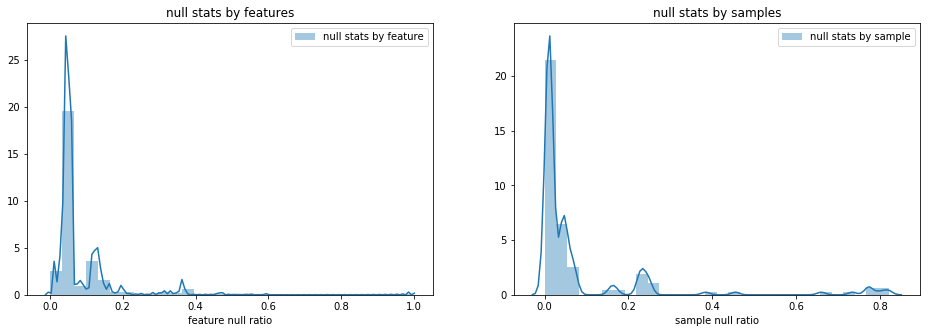

In [4]:
## null value statistics by columns and by rows
_ = data.isnull()
null_stats_row = _.sum(axis=1) / data.shape[1]
null_stats_col = _.sum(axis=0) / data.shape[0]

# plot the null statistics
f, axs = plt.subplots(1, 2, figsize=(16, 5))
sns.distplot(null_stats_row, ax=axs[0], bins=30, axlabel= 'feature null ratio', label='null stats by feature').legend()
sns.distplot(null_stats_col, ax=axs[1], bins=30, axlabel='sample null ratio', label='null stats by sample').legend()
axs[0].set_title('null stats by features')
axs[1].set_title('null stats by samples')
plt.show()

`Comment:
    From the 'null stats by features' plot, we can found that most of features have low null ratio, i.e. less than 0.2, so we choose 0.2 as the threshold to drop these features with null ratio geater than 0.2.
    From the 'null stats by samples' plot, we can found that most of samples have low null ratio, i.e. less than 0.4, so we choose 0.4 as the threshold to drop these samples with null ratio greater than 0.4.`

## Extract histogram features

In [5]:
## There are some features are derived from original attributes.
## E.g. features 'ee_000, ee_001, ee_002, ee_003, ee_004, ee_005, ee_006, ee_007, ee_008, ee_009' were derived from original attribute 'ee' by applying histogram to bin it.
## I.e., let's say there are N_i values in that original attribute 'ee' of a sample_i (other samples may have different number of values, i.e. N_j may be differ from N_i), 
## there is a count n_0 of values that fall into range 'ee_000', a count n_1 of values that fall into range 'ee_001' and so on,
## then assign n_0 to feature 'ee_000', assign n_1 to feature 'ee_001' and so on.
## So, if we apply argmax('ee000, ..., ee009'), then we can get the bin the original attribute 'ee' is falls into most frequently, 
## we use it as a new feature and vice versa (i.e. argmin('ee000, ..., ee009'))
original_attrs = [attr for attr, count in Counter([col[:2] for col in data.columns]).items() if count > 1]
for attr in original_attrs:
    data[f'{attr}_max'] = data.filter(regex=f"^{attr}_[0-9]*$").apply(lambda row: np.nanargmax(row) if not np.isnan(row).any() else np.NaN, 
                                                                      axis=1, raw=True, result_type='reduce')
    data[f'{attr}_min'] = data.filter(regex=f"^{attr}_[0-9]*$").apply(lambda row: np.nanargmin(row) if not np.isnan(row).any() else np.NaN, 
                                                                      axis=1, raw=True, result_type='reduce')
## normalize the histogram features
for attr in original_attrs:
    _df = data.filter(regex=f"^{attr}_[0-9]*$").apply(lambda row: row / np.nansum(row) if not np.nansum(row) == 0 else [0] * len(row), 
                                                      axis=1, raw=True, result_type='expand').add_suffix('_norm')
    data = pd.concat([data, _df], axis=1)

# Data Preprocessing

## Drop null values

In [6]:
## drop features and columns by threshold
# use 0.4 as feature null stats threshold to drop features
# use 0.2 as sample null stats threshold to drop samples
THRESHOLD_COL = 0.2
THRESHOLD_ROW = 0.4
drop_features = null_stats_col.index[null_stats_col > THRESHOLD_COL]
drop_samples = null_stats_row.index[null_stats_row > THRESHOLD_ROW]
data.drop(drop_features, axis=1, inplace=True)
data.drop(drop_samples, axis=0, inplace=True)
target.drop(drop_samples, inplace=True)

## Fill null values with mean and create null indicator features

In [7]:
## fill null values with mean strategy, and create null value indicator features
imp_mean = SimpleImputer(missing_values=np.NaN, strategy='mean', add_indicator=True).fit(data)
data = pd.DataFrame(imp_mean.transform(data), columns=data.columns.to_list() + (data.columns[imp_mean.indicator_.features_] + '_null_indic').to_list())

## Convert to proper dtypes

In [8]:
## convert float dtype columns with only integers to int dtype
# NOTE: make sure there is no NaN value
for col in data.columns:
    if data[col].apply(float.is_integer, convert_dtype=False).all():
        data[col] = data[col].astype(np.int)
# reduce memory usage
data = utils.reduce_mem_usage(data)

## Save preprocessed data

In [15]:
data.to_pickle('./preprc_data.pkl')

# Modeling